## **0.0 Imports**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn import cluster as c
from sklearn import metrics as m

from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import umap.umap_ as umap

/home/romulo/Documentos/PA005/insiders-clustering-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 0.1 Helper Functions

### 0.2 Load Dataset

In [2]:
# laod dataset
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding = 'unicode_escape')

# drop extra column
df_raw = df_raw.drop(columns = ['Unnamed: 8'], axis=1)

In [3]:
df_raw.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

## **1.0 Descrição dos dados**

In [4]:
df1 = df_raw.copy()

### **1.1 Rename columns**

In [5]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

df1.columns  = cols_new

### **1.2 Data dimensions**

In [6]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 541909
Number of cols: 8


### **1.3 Data types**

In [7]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [8]:
df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


### **1.4 Check NA**

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

### **1.5 Replace NA**

In [10]:
# remove NA
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}'.format( 1-( df1.shape[0] / df_raw.shape[0] ) ) )

Removed data: 0.25


In [11]:
df1.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

### **1.6 Changes dTypes**

In [12]:
# invoice date
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y' )

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id            float64
country                 object
dtype: object

### **1.7 Descriptive Statistics**

## **2.0 Feature Engineering**

In [14]:
df2 = df1.copy()

In [15]:
df2.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850.0,United Kingdom


### **2.1 Feature Criation**

In [16]:
# data reference
df_ref = df2.drop(['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'country'], axis = 1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


In [17]:
# Gross Revenue (Faturamento) quantity * price
df2['gross_revenue'] = df2['quantity'] * df2['unit_price']

In [18]:
# Monetary
df_monetary = df2[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')

In [19]:
# Recency - Last day purchase
df_recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

In [20]:
# Frequency - Quantity 
df_freq = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')

In [21]:
# Avg Ticket
df_avg_ticket = df2[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue':'avg_ticket'})
df_ref = pd.merge(df_ref, df_avg_ticket, on='customer_id', how='left')

In [22]:
df_ref

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850.0,5288.63,302,35,16.950737
1,13047.0,3079.10,31,18,15.709694
2,12583.0,7187.34,2,18,28.634821
3,13748.0,948.25,95,5,33.866071
4,15100.0,635.10,330,6,105.850000
...,...,...,...,...,...
4367,13436.0,196.89,1,1,16.407500
4368,15520.0,343.50,1,1,19.083333
4369,13298.0,360.00,1,1,180.000000
4370,14569.0,227.39,1,1,18.949167


## **3.0 Filtragem de Variáveis**

In [23]:
df3 = df_ref.copy()

## **4.0 EDA (Exploratory Data Analysis)**

In [24]:
df4 = df3.copy()

## **5.0 Data Preparation**

In [25]:
df5 = df4.copy()

## **6.0 Feature Selection**

In [26]:
df6 = df5.copy()

## **7.0 Hyperparameter Fine Tuning**

In [27]:
X = df6.drop(columns=['customer_id'])

In [28]:
clusters = [2, 3, 4, 5, 6, 7]

### **7.1 Within-Cluster Sum of Square (WSS)**

Text(0.5, 1.0, 'WSS vs K')

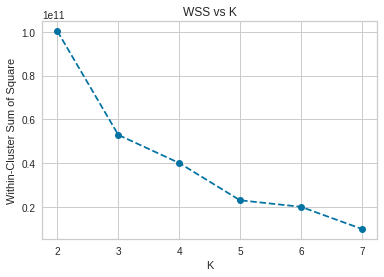

In [29]:
wss = []
for k in clusters:
    # model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

    #model training
    kmeans.fit(X)

    # validation
    wss.append(kmeans.inertia_)

# plot wss
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Within-Cluster Sum of Square')
plt.title('WSS vs K')

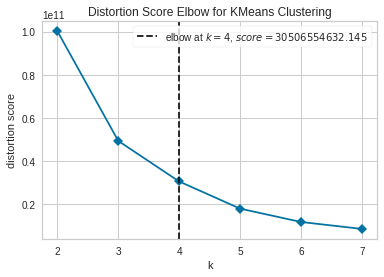

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [30]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings = False)
kmeans.fit(X)
kmeans.show()

*WSS definiu K = 4*

### **7.2 Silhouette Score**

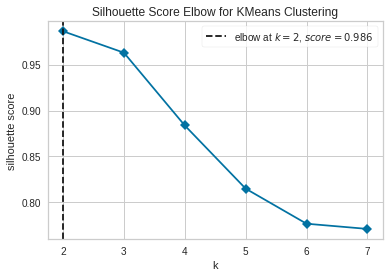

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [31]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings = False)
kmeans.fit(X)
kmeans.show()

*Silhouette Score definiu K = 2*

### **7.3 Silhouette Analysis**

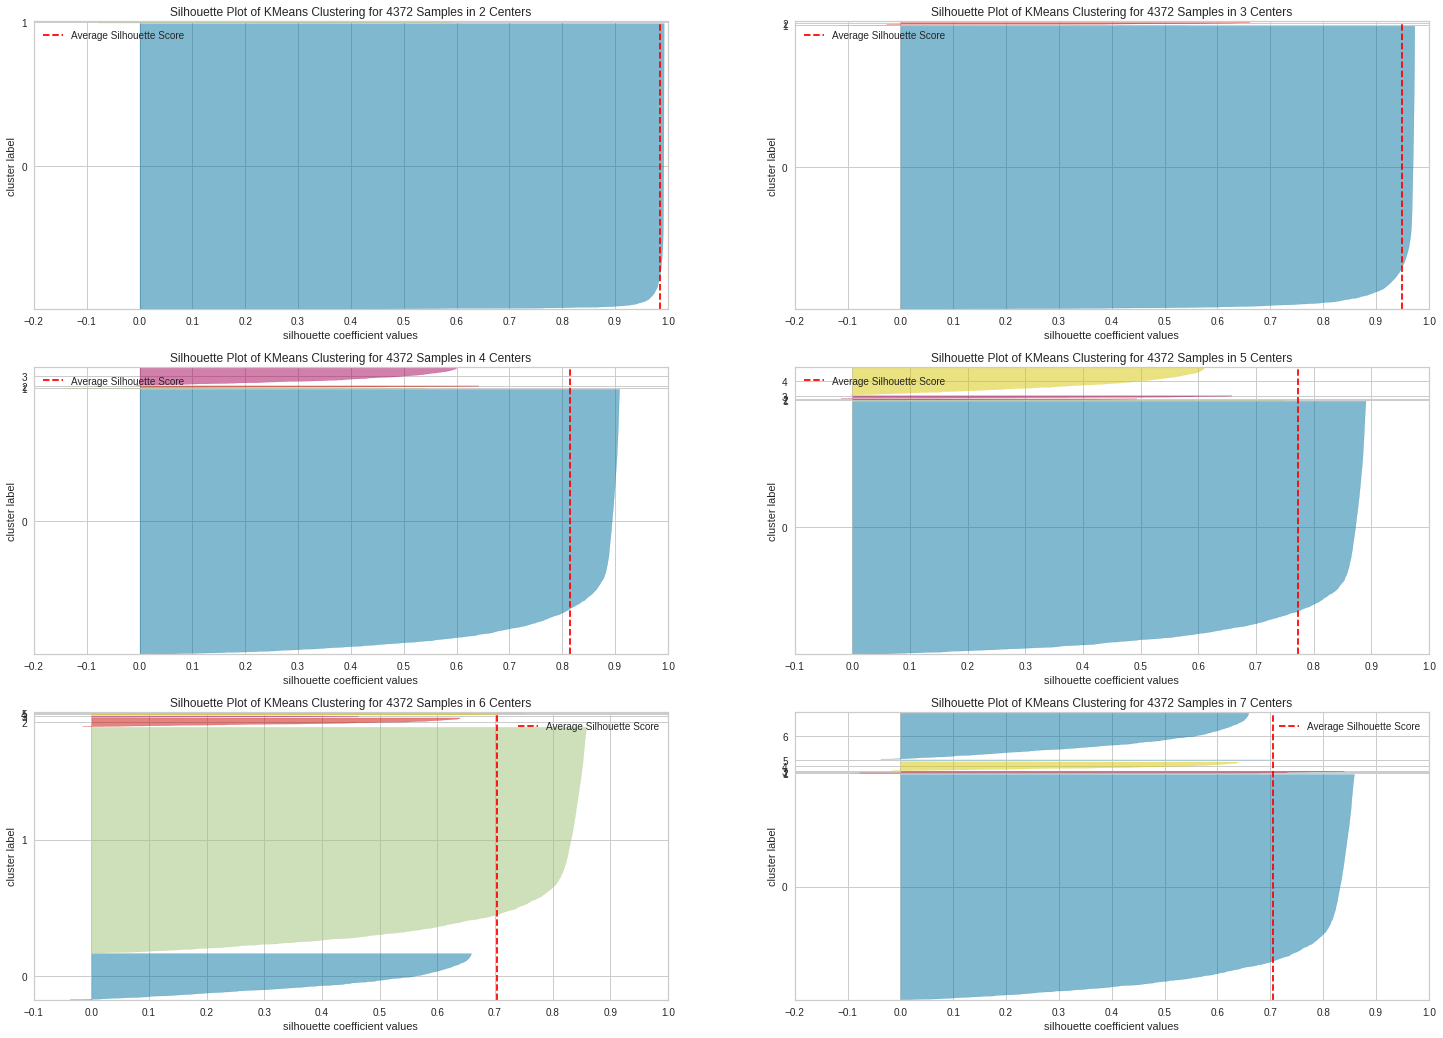

In [32]:
k = [2, 3, 4, 5, 6, 7]

fig, ax = plt.subplots(3, 2, figsize=(25, 18))

for k in clusters:
    km = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    q, mod = divmod(k, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

## **8.0 Model Training**

### **8.1 Models**

#### **8.1.1 K-Means**

In [33]:
# model definition
k = 4
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### **8.2 Cluster Validation**

In [34]:
# WSS (Within Cluster sum of square)
print('WSS: {}'.format(kmeans.inertia_))

# SS (Silhouette Score)
print('SS: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS: 40056506734.60243
SS: 0.8139972028952444


## **9.0 Cluster Analysis**

In [35]:
df9 = df6.copy()
df9['cluster'] = labels

In [36]:
df9.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket,cluster
0,17850.0,5288.63,302,35,16.950737,3
1,13047.0,3079.10,31,18,15.709694,0
2,12583.0,7187.34,2,18,28.634821,3
3,13748.0,948.25,95,5,33.866071,0
4,15100.0,635.10,330,6,105.850000,0


### **9.1 Vizualizer Inspection**

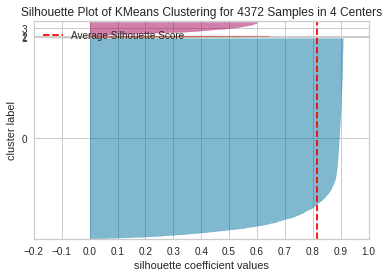

In [37]:
k = 4
km = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

### **9.2 2d Plot**

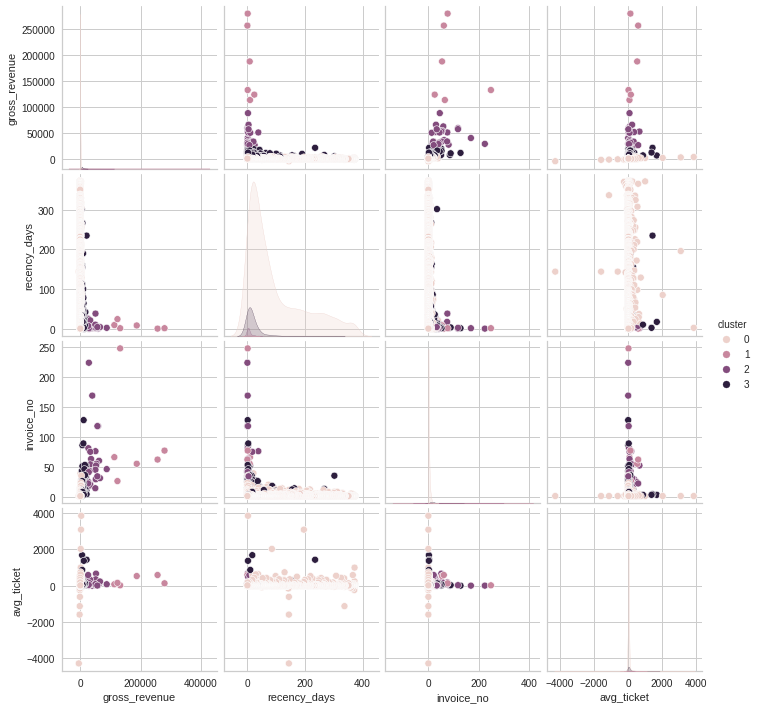

In [38]:
df_viz = df9.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

### **9.3 UMAP**

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

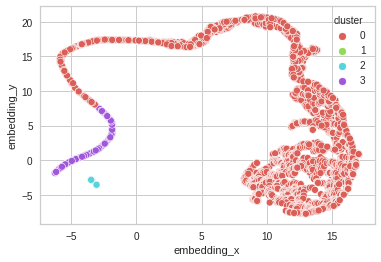

In [48]:
reducer = umap.UMAP(n_neighbors=15, random_state=42)
embedding = reducer.fit_transform(X)

#embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster', palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())), data=df_viz)

### **9.4 Cluster Profile**

In [40]:
# number of customers
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customers'] = 100 * (df_cluster['customer_id']/df_cluster['customer_id'].sum())

# gross revenue
df_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_gross_revenue, how='inner', on='cluster')

# recency days
df_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days, how='inner', on='cluster')

# invoice number
df_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_invoice_no, how='inner', on='cluster')

# Average Ticket
df_avg_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, how='inner', on='cluster')


df_cluster

,cluster,customer_id,perc_customers,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,4071,93.115279,946.696250,96.969295,3.641120,25.359654
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157


### Cluster 00: 
    - Número de customers: 93.11%
    - Recência média:      97 dias
    - Compra em média:     4 compras
    - Receita média:       $ 947,00
    - Ticket médio:    $ 25,36

### Cluster 01:
    - Número de customers: 0.14%
    - Recência média:      7 dias
    - Compra em média:     89 compras
    - Receita média:       $ 182.181,98
    - Ticket médio:    $ 253,62

### Cluster 02:
    - Número de customers: 0.64%
    - Recência média:      6 dias
    - Compra em média:     58 compras
    - Receita média:       $ 42.614,39
    - Ticket médio:    $ 162,86

### Cluster 03:
    - Número de customers: 6.10%
    - Recência média:      20 dias
    - Compra em média:     19 compras
    - Receita média:       $ 8.089,03
    - Ticket médio:    $ 62,87

## **10.0 Deploy to Production**